In [1]:
# Time-frequency transform of eeg data
import os
import pandas as pd
import numpy as np
import mne
from matplotlib import pyplot as plt
from tqdm import tqdm
import multiprocessing

mne.viz.set_browser_backend('matplotlib')

# Params
sfreq = 200
n_jobs = 32
n_cycles = 10.0  # default 7.0
freqs = np.arange(0.5, 20, 0.7) # default np.arange(0.5, 20, 0.7)
decim = 20  # default 20
ch_list = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
ch_pairs = [('Fp1', 'F7'), ('F7', 'T3'), ('T3', 'T5'), ('T5', 'O1'), 
            ('Fp2', 'F8'), ('F8', 'T4'), ('T4', 'T6'), ('T6', 'O2'), 
            ('Fp1', 'F3'), ('F3', 'C3'), ('C3', 'P3'), ('P3', 'O1'), 
            ('Fp2', 'F4'), ('F4', 'C4'), ('C4', 'P4'), ('P4', 'O2'), 
            ('Fz', 'Cz'), ('Cz', 'Pz')]
bundles = [('Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1'), 
           ('Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2'), 
           ('Fp1-F3', 'F3-C3', 'C3-P3', 'P3-O1'), 
           ('Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2'), 
           ('Fz-Cz', 'Cz-Pz'),
           ('EKG',)]
sub_ch_list = ['-'.join(pair) for pair in ch_pairs]

eeg_tf_type = '' # Use 0.7 Hz tf resolution, 0.5-00 Hz range, morlet wavelet
# eeg_tf_type = '_bundles' # Use 6 bundles based on rater images, 0.25 Hz tf resolution
# eeg_tf_type = '_bundles_multitaper' # Use 6 bundles based on rater images, 0.25 Hz tf resolution, multitaper (instead of morlet)
# eeg_tf_type = '_10hz' # Use 0.4 Hz tf resolution, 0.5-10 Hz range
# eeg_tf_type = '_30hz' # Use 1.1 Hz tf resolution, 0.5-30 Hz range
# eeg_tf_type = '_globalnorm' # Same as '' but with global normalization (ECG normalized separately)
# eeg_tf_type = '_bundles_globalnorm' # Same as '_bundles' but with global normalization (ECG normalized separately)
# eeg_tf_type = '_bundles_globalnorm_ncycles3' # Same as '_bundles' but with global normalization (ECG normalized separately), n_cycles 3.0
# eeg_tf_type = '_bundles_globalnorm_ncycles10' # Same as '_bundles' but with global normalization (ECG normalized separately), n_cycles 10.0
# eeg_tf_type = '_globalnorm_alltr' # Same as '' but with global normalization (ECG normalized separately), all trials
eeg_tf_type = '_globalnorm_ncycles10' # Same as '_globalnorm' but with n_cycles 10.0
# eeg_tf_type = '_globalnorm_highres1' # Same as '_globalnorm' but higher resolution (0.4 Hz steps, decim 10)

# Paths
root = '/media/latlab/MR/projects/kaggle-hms'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
# out_dir = os.path.join(data_dir, 'eeg_tf')
# os.makedirs(out_dir, exist_ok=True)

# Load data
df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df = df.groupby('eeg_id').head(1).reset_index(drop=True)    # Only keep first row for each eeg_id
eeg_data = np.load(os.path.join(data_dir, 'eeg_data.npy'), allow_pickle=True).item()
display(df)

Using matplotlib as 2D backend.


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5
2,722738444,0,0.0,999431,0,0.0,557980729,56885,LRDA,0,1,0,14,0,1
3,387987538,0,0.0,1084844,0,0.0,4099147263,4264,LRDA,0,0,0,3,0,0
4,2175806584,0,0.0,1219001,0,0.0,1963161945,23435,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,3910994355,0,0.0,2146798838,0,0.0,4272062867,28488,LPD,0,9,0,2,0,7
17085,3938393892,0,0.0,2146798838,1,60.0,2587113091,28488,LPD,0,9,0,2,0,7
17086,1850739625,0,0.0,2146798838,3,162.0,2394534310,28488,LPD,0,9,0,2,0,7
17087,1306668185,0,0.0,2147312808,0,0.0,1216355904,57480,LPD,0,3,0,0,0,0


In [2]:
chunk_size = df.shape[0] // n_jobs
chunks = [df.iloc[df.index[i:i + chunk_size]] for i in range(0, df.shape[0], chunk_size)]

def get_tf_data(df):
    mne.set_log_level('warning')
    eeg_tf_data = dict()
    for row in tqdm(df.itertuples(), total=len(df)):
        data = eeg_data[row.eeg_id]
        data = np.nan_to_num(data, nan=0.0)
        arr_list = []
        for (ch1, ch2) in ch_pairs:
            arr_list.append(data[:,ch_list.index(ch1)] - data[:,ch_list.index(ch2)])
        arr_list.append(data[:,ch_list.index('EKG')])
        data = np.stack(arr_list, axis=0)

        tf_ch_names = sub_ch_list + ['EKG']
        raw = mne.io.RawArray(data, mne.create_info(ch_names=tf_ch_names, sfreq=sfreq, ch_types=['eeg']*(len(sub_ch_list)) + ['ecg']))
        raw = raw.crop(tmin=row.eeg_label_offset_seconds, tmax=row.eeg_label_offset_seconds + 50, include_tmax=False)
        data = np.expand_dims(raw.get_data(), axis=0)

        tf = mne.time_frequency.tfr_array_morlet(data, sfreq, freqs=freqs, output='power', n_jobs=1, decim=decim, n_cycles=n_cycles)
        tf = tf.squeeze()

        # # create bundles
        # tf_arr_list = []
        # for i, bundle in enumerate(bundles):
        #     bundle_idx = [tf_ch_names.index(ch) for ch in bundle]
        #     tf_arr_list.append(np.mean(tf[bundle_idx,...], axis=0))
        # tf = np.stack(tf_arr_list, axis=0)

        # log transform
        tf = np.log(tf)

        # standardize per image
        # for i in range(tf.shape[0]):
        #     ep = 1e-6
        #     m = np.nanmean(tf[i,...].flatten())
        #     s = np.nanstd(tf[i,...].flatten())
        #     tf[i,...] = (tf[i,...]-m)/(s+ep)
        # tf = np.nan_to_num(tf, nan=0.0)
        # img = np.reshape(tf, (-1, tf.shape[-1]))

        ep = 1e-6
        m = np.nanmean(tf[:-1,...].flatten())
        s = np.nanstd(tf[:-1,...].flatten())
        tf[:-1,...] = (tf[:-1,...]-m)/(s+ep)
        m = np.nanmean(tf[[-1],...].flatten())
        s = np.nanstd(tf[[-1],...].flatten())
        tf[[-1],...] = (tf[[-1],...]-m)/(s+ep)
        tf = np.nan_to_num(tf, nan=0.0)
        img = np.reshape(tf, (-1, tf.shape[-1]))

        # np.save(os.path.join(out_dir, f'{row.eeg_id}_{row.eeg_sub_id}'), img.astype(np.float32))
        eeg_tf_data[row.eeg_id] = img.astype(np.float32)

        del raw, data, tf, img

    return eeg_tf_data

In [3]:
# eeg_tf_data = get_tf_data(df)

pool = multiprocessing.Pool(processes=n_jobs)
results = pool.map(get_tf_data, chunks)
eeg_tf_data = {k: v for d in results for k, v in d.items()}

  0%|          | 1/534 [00:01<12:05,  1.36s/it]/tmp/ipykernel_1605914/3054776562.py:32: RuntimeWarning: divide by zero encountered in log
  tf = np.log(tf)
  0%|          | 1/534 [00:01<12:11,  1.37s/it]/home/latlab/anaconda3/envs/hms/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
  0%|          | 1/534 [00:01<12:30,  1.41s/it]/tmp/ipykernel_1605914/3054776562.py:46: RuntimeWarning: invalid value encountered in subtract
  tf[:-1,...] = (tf[:-1,...]-m)/(s+ep)
  0%|          | 1/534 [00:01<13:06,  1.48s/it]/tmp/ipykernel_1605914/3054776562.py:49: RuntimeWarning: invalid value encountered in subtract
  tf[[-1],...] = (tf[[-1],...]-m)/(s+ep)
  0%|          | 2/534 [00:02<08:32,  1.04it/s]/tmp/ipykernel_1605914/3054776562.py:32: RuntimeWarning: divide by zero encountered in log
  tf = np.log(tf)
/home/latlab/anaconda3/envs/hms/lib/python3.11/site-packages/numpy

(741, 715)


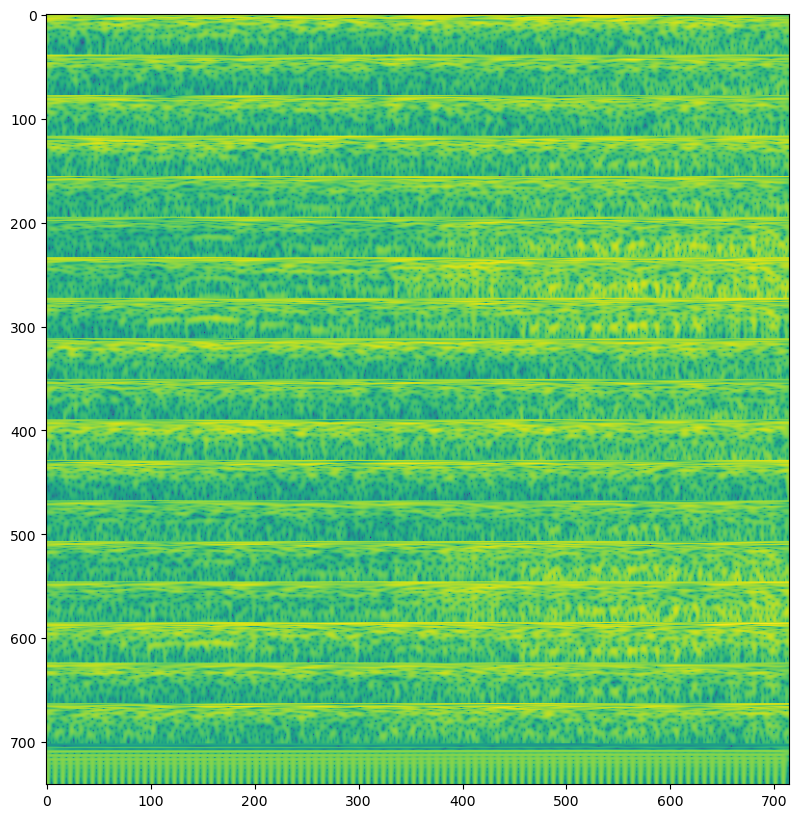

In [10]:
# freqs = np.arange(0.5, 20, 0.5) # default np.arange(0.5, 20, 0.7)
# decim = 14  # default 20

# # Testing single eeg_id
# eeg_id = df['eeg_id'].unique()[0]

# mne.set_log_level('warning')
# data = eeg_data[eeg_id]
# data = np.nan_to_num(data, nan=0.0)
# arr_list = []
# for (ch1, ch2) in ch_pairs:
#     arr_list.append(data[:,ch_list.index(ch1)] - data[:,ch_list.index(ch2)])
# arr_list.append(data[:,ch_list.index('EKG')])
# data = np.stack(arr_list, axis=0)

# tf_ch_names = sub_ch_list + ['EKG']
# raw = mne.io.RawArray(data, mne.create_info(ch_names=tf_ch_names, sfreq=sfreq, ch_types=['eeg']*(len(sub_ch_list)) + ['ecg']))
# raw = raw.crop(tmin=0, tmax=0 + 50, include_tmax=False)
# data = np.expand_dims(raw.get_data(), axis=0)

# tf = mne.time_frequency.tfr_array_morlet(data, sfreq, freqs=freqs, output='power', n_jobs=n_jobs, decim=decim, n_cycles=n_cycles)
# tf = tf.squeeze()

# # # create bundles
# # tf_arr_list = []
# # for i, bundle in enumerate(bundles):
# #     bundle_idx = [tf_ch_names.index(ch) for ch in bundle]
# #     tf_arr_list.append(np.mean(tf[bundle_idx,...], axis=0))
# # tf = np.stack(tf_arr_list, axis=0)

# # log transform
# tf = np.log(tf)

# # standardize per image
# # for i in range(tf.shape[0]):
# #     ep = 1e-6
# #     m = np.nanmean(tf[i,...].flatten())
# #     s = np.nanstd(tf[i,...].flatten())
# #     tf[i,...] = (tf[i,...]-m)/(s+ep)
# #     tf[i,...] = np.nan_to_num(tf[i,...], nan=0.0)
# # tf = np.nan_to_num(tf, nan=0.0)

# ep = 1e-6
# m = np.nanmean(tf[:-1,...].flatten())
# s = np.nanstd(tf[:-1,...].flatten())
# tf[:-1,...] = (tf[:-1,...]-m)/(s+ep)
# m = np.nanmean(tf[[-1],...].flatten())
# s = np.nanstd(tf[[-1],...].flatten())
# tf[[-1],...] = (tf[[-1],...]-m)/(s+ep)
# tf = np.nan_to_num(tf, nan=0.0)

# img = np.reshape(tf, (-1, tf.shape[-1]))

# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# print(img.shape)

In [5]:
np.save(os.path.join(data_dir, f'eeg_tf_data{eeg_tf_type}.npy'), eeg_tf_data)

In [6]:
# %%time
# test_data = np.load(os.path.join(data_dir, f'eeg_tf_data{eeg_tf_type}.npy'), allow_pickle=True).item()